In [ ]:
# Install pytorch geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

In [ ]:
from __future__ import division
from __future__ import unicode_literals
import os
# import os.path as osp
import numpy as np
import pandas as pd
import sympy as sym
import torch
import datetime
import math
from math import sqrt, pi as PI
from tqdm import tqdm

import torch.nn as nn
from torch.nn import Linear, Embedding

import torch.optim as optim

from torch_sparse import SparseTensor
from torch_scatter import scatter
import torch_cluster

from torch_geometric.nn import radius_graph
from torch_geometric.nn.acts import swish
from torch_geometric.nn.inits import glorot_orthogonal
from torch_geometric.nn.models.dimenet_utils import bessel_basis, real_sph_harm

from torch_geometric.data import Data, DataLoader

from sklearn.metrics import r2_score, mean_absolute_error as MAE
from torch.optim.optimizer import Optimizer, required
import torch

from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
plt.rcParams.update({'font.size': 20})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Envelope(torch.nn.Module):
    def __init__(self, exponent):
        super(Envelope, self).__init__()
        self.p = exponent + 1
        self.a = -(self.p + 1) * (self.p + 2) / 2
        self.b = self.p * (self.p + 2)
        self.c = -self.p * (self.p + 1) / 2

    def forward(self, x):
        p, a, b, c = self.p, self.a, self.b, self.c
        x_pow_p0 = x.pow(p - 1)
        x_pow_p1 = x_pow_p0 * x
        x_pow_p2 = x_pow_p1 * x
        return 1. / x + a * x_pow_p0 + b * x_pow_p1 + c * x_pow_p2


class BesselBasisLayer(torch.nn.Module):
    def __init__(self, num_radial, cutoff=5.0, envelope_exponent=5):
        super(BesselBasisLayer, self).__init__()
        self.cutoff = cutoff
        self.envelope = Envelope(envelope_exponent)

        # Initialize frequencies at canonical positions
        self.freq = torch.nn.Parameter(torch.Tensor(num_radial))

        self.reset_parameters()

    def reset_parameters(self):
        torch.arange(1, self.freq.numel() + 1, out=self.freq).mul_(PI)

    def forward(self, dist):
        dist = dist.unsqueeze(-1) / self.cutoff
        return self.envelope(dist) * (self.freq * dist).sin()


class SphericalBasisLayer(torch.nn.Module):
    def __init__(self, num_spherical, num_radial, cutoff=5.0,
                 envelope_exponent=5):
        super(SphericalBasisLayer, self).__init__()
        assert num_radial <= 64
        self.num_spherical = num_spherical
        self.num_radial = num_radial
        self.cutoff = cutoff
        self.envelope = Envelope(envelope_exponent)

        bessel_forms = bessel_basis(num_spherical, num_radial)
        sph_harm_forms = real_sph_harm(num_spherical)
        self.sph_funcs = []
        self.bessel_funcs = []

        x, theta = sym.symbols('x theta')
        modules = {'sin': torch.sin, 'cos': torch.cos}
        for i in range(num_spherical):
            if i == 0:
                sph1 = sym.lambdify([theta], sph_harm_forms[i][0], modules)(0)
                self.sph_funcs.append(lambda x: torch.zeros_like(x) + sph1)
            else:
                sph = sym.lambdify([theta], sph_harm_forms[i][0], modules)
                self.sph_funcs.append(sph)
            for j in range(num_radial):
                bessel = sym.lambdify([x], bessel_forms[i][j], modules)
                self.bessel_funcs.append(bessel)

    def forward(self, dist, angle, idx_kj):
        dist = dist / self.cutoff
        rbf = torch.stack([f(dist) for f in self.bessel_funcs], dim=1)
        rbf = self.envelope(dist).unsqueeze(-1) * rbf

        cbf = torch.stack([f(angle) for f in self.sph_funcs], dim=1)

        n, k = self.num_spherical, self.num_radial
        out = (rbf[idx_kj].view(-1, n, k) * cbf.view(-1, n, 1)).view(-1, n * k)
        return out


class Embedder(nn.Module):
    def __init__(self,
                 d_model,
                 compute_device=None):
        super().__init__()
        self.d_model = d_model
        self.compute_device = torch.device('cuda')

        # mat2vec element embeddings
        cbfv = pd.read_csv('drive/My Drive/DimeNet/mat2vec.csv',
                           index_col=0).values
        feat_size = cbfv.shape[-1]
        self.fc_mat2vec = nn.Linear(feat_size,
                                    self.d_model).to(self.compute_device)
        zeros = np.zeros((1, feat_size))
        cat_array = np.concatenate([zeros, cbfv])
        cat_array = torch.as_tensor(cat_array, dtype=torch.float)
        self.cbfv = nn.Embedding.from_pretrained(cat_array) \
            .to(self.compute_device, dtype=torch.float)

    def forward(self, src, i):
        mat2vec_emb = self.cbfv(src)  # src is tensor of z
        x_emb = self.fc_mat2vec(mat2vec_emb[i])  # put it through the network
        return x_emb  # the 128 thing (hidden_channels)


class EmbeddingBlock(torch.nn.Module):
    def __init__(self, num_radial, hidden_channels, act=swish):
        super(EmbeddingBlock, self).__init__()
        self.act = act

        self.emb = Embedding(119, hidden_channels)
        self.lin_rbf = Linear(num_radial, hidden_channels)
        self.lin = Linear(3 * hidden_channels, hidden_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.emb.weight.data.uniform_(-sqrt(3), sqrt(3))
        self.lin_rbf.reset_parameters()
        self.lin.reset_parameters()

    def forward(self, x, rbf, i, j):
        x = self.emb(x)
        rbf = self.act(self.lin_rbf(rbf))
        return self.act(self.lin(torch.cat([x[i], x[j], rbf], dim=-1)))


class ResidualLayer(torch.nn.Module):
    def __init__(self, hidden_channels, act=swish):
        super(ResidualLayer, self).__init__()
        self.act = act
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)

        self.reset_parameters()

    def reset_parameters(self):
        glorot_orthogonal(self.lin1.weight, scale=2.0)
        self.lin1.bias.data.fill_(0)
        glorot_orthogonal(self.lin2.weight, scale=2.0)
        self.lin2.bias.data.fill_(0)

    def forward(self, x):
        return x + self.act(self.lin2(self.act(self.lin1(x))))


class InteractionBlock(torch.nn.Module):
    def __init__(self, hidden_channels, int_emb_size, basis_emb_size,
                 num_bilinear, num_spherical, num_radial, num_before_skip,
                 num_after_skip, act=swish):
        super(InteractionBlock, self).__init__()
        self.act = act

        # Transformations of Bessel and spherical basis representations
        self.lin_rbf1 = Linear(num_radial, basis_emb_size, bias=False)
        self.lin_rbf2 = Linear(basis_emb_size, hidden_channels, bias=False)

        self.lin_sbf1 = Linear(num_radial * num_spherical, basis_emb_size,
                               bias=False)
        self.lin_sbf2 = Linear(basis_emb_size, int_emb_size,
                               bias=False)

        # Dense transformations of input messages.
        self.lin_kj = Linear(hidden_channels, hidden_channels)
        self.lin_ji = Linear(hidden_channels, hidden_channels)

        # Embedding projections for interaction triplets
        self.down_projection = Linear(hidden_channels, int_emb_size,
                                      bias=False)
        self.up_projection = Linear(int_emb_size, hidden_channels, bias=False)

        # Residual layers before skip connection
        self.layers_before_skip = torch.nn.ModuleList([
            ResidualLayer(hidden_channels, act) for _ in range(num_before_skip)
        ])
        self.lin = Linear(hidden_channels, hidden_channels)  # last before skip

        # Residual layers after skip connection
        self.layers_after_skip = torch.nn.ModuleList([
            ResidualLayer(hidden_channels, act) for _ in range(num_after_skip)
        ])

        self.reset_parameters()

    def reset_parameters(self):
        glorot_orthogonal(self.lin_rbf1.weight, scale=2.0)
        glorot_orthogonal(self.lin_rbf2.weight, scale=2.0)
        glorot_orthogonal(self.lin_sbf1.weight, scale=2.0)
        glorot_orthogonal(self.lin_sbf2.weight, scale=2.0)

        glorot_orthogonal(self.lin_kj.weight, scale=2.0)
        self.lin_kj.bias.data.fill_(0)
        glorot_orthogonal(self.lin_ji.weight, scale=2.0)
        self.lin_ji.bias.data.fill_(0)

        glorot_orthogonal(self.down_projection.weight, scale=2.0)
        glorot_orthogonal(self.up_projection.weight, scale=2.0)

        for res_layer in self.layers_before_skip:
            res_layer.reset_parameters()
        glorot_orthogonal(self.lin.weight, scale=2.0)
        self.lin.bias.data.fill_(0)
        for res_layer in self.layers_after_skip:
            res_layer.reset_parameters()

    def forward(self, x, rbf, sbf, idx_kj, idx_ji):
        # Initial transformation
        x_ji = self.act(self.lin_ji(x))
        x_kj = self.act(self.lin_kj(x))

        # Transform via Bessel basis
        rbf = self.lin_rbf1(rbf)
        rbf = self.lin_rbf2(rbf)
        x_kj = x_kj * rbf

        # Down-project embeddings and generate interaction triplet embeddings
        x_kj = self.act(self.down_projection(x_kj))

        # Transform via 2D spherical basis
        sbf = self.lin_sbf1(sbf)
        sbf = self.lin_sbf2(sbf)
        x_kj = x_kj[idx_kj] * sbf

        # Aggregate interactions and up-project embeddings
        x_kj = scatter(x_kj, idx_ji, dim=0, dim_size=x.size(0))
        x_kj = self.up_projection(x_kj)

        # Transformations before skip connection
        h = x_ji + x_kj
        for layer in self.layers_before_skip:
            h = layer(h)
        h = self.act(self.lin(h)) + x

        # Transformations after skip connection
        for layer in self.layers_after_skip:
            h = layer(h)

        return h


class OutputBlock(torch.nn.Module):
    def __init__(self, num_radial, hidden_channels, out_emb_size,
                 out_channels, num_layers, act=swish):
        super(OutputBlock, self).__init__()
        self.act = act

        self.lin_rbf = Linear(num_radial, hidden_channels, bias=False)

        self.up_projection = Linear(hidden_channels, out_emb_size, bias=False)

        self.lins = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.lins.append(Linear(out_emb_size, out_emb_size))
        self.lin = Linear(out_emb_size, out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        glorot_orthogonal(self.lin_rbf.weight, scale=2.0)
        glorot_orthogonal(self.up_projection.weight, scale=2.0)
        for lin in self.lins:
            glorot_orthogonal(lin.weight, scale=2.0)
            lin.bias.data.fill_(0)
        self.lin.weight.data.fill_(0)

    def forward(self, x, rbf, i, num_nodes=None):
        x = self.lin_rbf(rbf) * x
        # print("outputblock x:", x.shape)
        x = scatter(x, i, dim=0, dim_size=num_nodes)
        # print("outputblock x:", x.shape)
        x = self.up_projection(x)
        # print("outputblock x:", x.shape)

        for lin in self.lins:
            x = self.act(lin(x))
        return self.lin(x)


class DimeNet(torch.nn.Module):
    r"""The directional message passing neural network (DimeNet) from the
    `"Directional Message Passing for Molecular Graphs"
    <https://arxiv.org/abs/2003.03123>`_ paper.
    DimeNet transforms messages based on the angle between them in a
    rotation-equivariant fashion.
    .. note::
        For an example of using a pretrained DimeNet variant, see
        `examples/qm9_pretrained_dimenet.py
        <https://github.com/rusty1s/pytorch_geometric/blob/master/examples/
        qm9_pretrained_dimenet.py>`_.
    Args:
        hidden_channels (int): Hidden embedding size.
        out_channels (int): Size of each output sample.
        num_blocks (int): Number of building blocks.
        num_bilinear (int): Size of the bilinear layer tensor.
        num_spherical (int): Number of spherical harmonics.
        num_radial (int): Number of radial basis functions.
        cutoff: (float, optional): Cutoff distance for interatomic
            interactions. (default: :obj:`5.0`)
        envelope_exponent (int, optional): Shape of the smooth cutoff.
            (default: :obj:`5`)
        num_before_skip: (int, optional): Number of residual layers in the
            interaction blocks before the skip connection. (default: :obj:`1`)
        num_after_skip: (int, optional): Number of residual layers in the
            interaction blocks after the skip connection. (default: :obj:`2`)
        num_output_layers: (int, optional): Number of linear layers for the
            output blocks. (default: :obj:`3`)
        act: (function, optional): The activation funtion.
            (default: :obj:`swish`)
    """

    def __init__(self, hidden_channels, out_channels, num_blocks, num_bilinear,
                 out_emb_size, int_emb_size, basis_emb_size, num_spherical,
                 num_radial, cutoff=5.0, envelope_exponent=5,
                 num_before_skip=1, num_after_skip=2, num_output_layers=3,
                 act=swish):
        super(DimeNet, self).__init__()

        self.cutoff = cutoff

        if sym is None:
            raise ImportError('Package `sympy` could not be found.')

        self.num_blocks = num_blocks

        # Cosine basis function expansion layer
        self.rbf = BesselBasisLayer(num_radial, cutoff, envelope_exponent)
        self.sbf = SphericalBasisLayer(num_spherical, num_radial, cutoff,
                                       envelope_exponent)

        # Embedding and output blocks
        self.emb = EmbeddingBlock(num_radial, hidden_channels, act)
        self.element_emb = Embedder(hidden_channels)

        self.output_blocks = torch.nn.ModuleList([
            OutputBlock(num_radial, hidden_channels, out_emb_size,
                        out_channels,
                        num_output_layers, act) for _ in range(num_blocks + 1)
        ])
        self.scaler = nn.parameter.Parameter(torch.tensor([1.]))

        # Interaction blocks
        self.interaction_blocks = torch.nn.ModuleList([
            InteractionBlock(hidden_channels,
                             int_emb_size,
                             basis_emb_size,
                             num_bilinear, num_spherical,
                             num_radial, num_before_skip, num_after_skip, act)
            for _ in range(num_blocks)
        ])

        self.reset_parameters()

    def reset_parameters(self):
        self.rbf.reset_parameters()
        self.emb.reset_parameters()
        for out in self.output_blocks:
            out.reset_parameters()
        for interaction in self.interaction_blocks:
            interaction.reset_parameters()

    def triplets(self, edge_index, num_nodes):
        row, col = edge_index  # j->i

        value = torch.arange(row.size(0), device=row.device)
        adj_t = SparseTensor(row=col, col=row, value=value,
                             sparse_sizes=(num_nodes, num_nodes))
        adj_t_row = adj_t[row]
        num_triplets = adj_t_row.set_value(None).sum(dim=1).to(torch.long)

        # Node indices (k->j->i) for triplets.
        idx_i = col.repeat_interleave(num_triplets)
        idx_j = row.repeat_interleave(num_triplets)
        idx_k = adj_t_row.storage.col()
        mask = idx_i != idx_k  # Remove i == k triplets.
        idx_i, idx_j, idx_k = idx_i[mask], idx_j[mask], idx_k[mask]

        # Edge indices (k-j, j->i) for triplets.
        idx_kj = adj_t_row.storage.value()[mask]
        idx_ji = adj_t_row.storage.row()[mask]

        return col, row, idx_i, idx_j, idx_k, idx_kj, idx_ji

    def forward(self, z, pos, batch=None):
        edge_index = radius_graph(pos, r=self.cutoff, batch=batch)

        i, j, idx_i, idx_j, idx_k, idx_kj, idx_ji = self.triplets(
            edge_index, num_nodes=z.size(0))

        # Calculate distances.
        dist = (pos[i] - pos[j]).pow(2).sum(dim=-1).sqrt()

        # Calculate angles -- revised version
        pos_i = pos[idx_i]
        pos_j = pos[idx_j]
        pos_k = pos[idx_k]

        pos_ji = pos_j - pos_i
        pos_kj = pos_k - pos_j

        a = (pos_ji * pos_kj).sum(dim=-1)
        b = torch.cross(pos_ji, pos_kj).norm(dim=-1)
        angle = torch.atan2(b, a)

        rbf = self.rbf(dist)
        # print('rbf shape', rbf.shape)
        sbf = self.sbf(dist, angle, idx_kj)

        # Embedding block.
        x = self.emb(z, rbf, i, j)  # embed atomic numbers
        ebfv = self.element_emb(z, i) * (2**(1-self.scaler)**2)  # mat2vec
        x = x + ebfv  # atomic numbers now have domain-relevant features

        P = self.output_blocks[0](x, rbf, i, num_nodes=pos.size(0))

        # Interaction blocks.
        for interaction_block, output_block in zip(self.interaction_blocks,
                                                   self.output_blocks[1:]):
            x = interaction_block(x, rbf, sbf, idx_kj, idx_ji)
            P += output_block(x, rbf, i)

        return P.sum(dim=0) if batch is None else scatter(P, batch, dim=0)

In [ ]:
# validation inference loop
def val_inference(model, loader):
    y_preds = []
    y_actual = []

    for data in tqdm(loader, leave=False):
        data = data.to(device)

        # get prediction
        with torch.no_grad():
            pred = model(data.z, data.pos, data.batch)

        y_preds.append(pred.view(-1))
        y_actual.append(data.y)

    y_preds = torch.cat(y_preds, dim=0).detach().cpu()
    y_actual = torch.cat(y_actual, dim=0).detach().cpu()

    mae = MAE(y_actual, y_preds)
    r2 = r2_score(y_actual, y_preds)

    print()
    print(f'Validating... '
          f'MAE: {mae:.3f}, '
          f'R2: {r2:.3f} on val_dataset, '
          f'completed at {datetime.datetime.now().strftime("%H:%M")}')
    return y_actual, y_preds, mae, r2


# test inference loop
def test_inference(model, loader):
    y_test, y_test_pred, mae, r2 = val_inference(model, loader)
    print(f'\nTest Results:\tMAE: {mae:.3f}, R2: {r2:.3f}')
    return y_test.numpy(), y_test_pred.numpy(), mae, r2

In [ ]:
def act_pred(y_act, y_pred, target, r2, mae,
             name='example',
             x_hist=True,
             y_hist=True,
             save_dir=None):

    mec = '#2F4F4F'
    mfc = '#C0C0C0'

    plt.figure(1, figsize=(6, 6), dpi=300)
    left, width = 0.1, 0.65

    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.15]
    rect_histy = [left_h, bottom, 0.15, height]

    ax2 = plt.axes(rect_scatter)
    ax2.tick_params(direction='in',
                    length=7,
                    top=True,
                    right=True)

    # add minor ticks
    minor_locator_x = AutoMinorLocator(2)
    minor_locator_y = AutoMinorLocator(2)
    ax2.get_xaxis().set_minor_locator(minor_locator_x)
    ax2.get_yaxis().set_minor_locator(minor_locator_y)
    plt.tick_params(which='minor',
                    direction='in',
                    length=4,
                    right=True,
                    top=True)

    # feel free to change the colors here.
    ax2.plot(y_act, y_pred, 'o', mfc='lightblue', alpha=0.5, label=None,
             mec='dimgrey', mew=1.2, ms=7)
    ax2.plot([-10**9, 10**9], [-10**9, 10**9], 'k--', alpha=0.8, lw=1.5,
             label='Ideal')

    label_units = {'matbench_jdft2d': 'E Exfol. [eV/atom]',
                   'matbench_phonons': 'PhDOS Peak [1/cm]',
                   'matbench_dielectric': '$n$',
                   'matbench_log_kvrh': 'log$(K)$ [log(GPa)]',
                   'matbench_log_gvrh': 'log$(G)$ [log(GPa)]',
                   'matbench_perovskites': '$E_{form}$ [eV]',
                   'matbench_mp_gap': '$E_{g}$ [eV]',
                   'matbench_mp_is_metal': 'Metallicity',
                   'matbench_mp_e_form': '$E_{form}$ [eV/atom]'}
    lab = label_units[target]

    ax2.set_ylabel(f'Predicted {lab}')
    ax2.set_xlabel(f'Actual {lab}')
    x_range = max(y_act) - min(y_act)
    ax2.set_xlim(max(y_act) - x_range*1.05,
                 min(y_act) + x_range*1.05)

    ax2.set_ylim(max(y_act) - x_range*1.05,
                 min(y_act) + x_range*1.05)

    ax1 = plt.axes(rect_histx)
    ax1_n, ax1_bins, ax1_patches = ax1.hist(y_act,
                                            bins=31,
                                            density=True,
                                            color=mfc,
                                            edgecolor='black',
                                            alpha=0)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_xlim(ax2.get_xlim())
    ax1.axis('off')

    if x_hist:
        [p.set_alpha(1.0) for p in ax1_patches]

    ax3 = plt.axes(rect_histy)
    ax3_n, ax3_bins, ax3_patches = ax3.hist(y_pred,
                                            bins=31,
                                            density=True,
                                            color=mfc,
                                            edgecolor='black',
                                            orientation='horizontal',
                                            alpha=0)
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_ylim(ax2.get_ylim())
    ax3.axis('off')

    if y_hist:
        [p.set_alpha(1.0) for p in ax3_patches]
    
    ax2.text(0, 2.3, f'$R^2={r2:.3f}$')
    ax2.text(0, 2.1, f'MAE$={mae:.3f}$')
    ax2.legend(loc='lower right', framealpha=0.35, handlelength=1.5)
    plt.draw()

    if save_dir is not None:
        fig_name = f'{save_dir}/{name}_act_pred.png'
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(fig_name, bbox_inches='tight', dpi=300)
    # plt.draw()
    # plt.pause(0.001)
    # plt.close()
    plt.show()

In [ ]:
def loss_curve(x_data, train_err, val_err, name='example', save_dir=None):

    mec1 = 'black'
    mfc1 = '#003f5c'
    mec2 = 'maroon'
    mfc2 = 'pink'

    fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

    ax.plot(x_data, train_err, marker='o', ms=8, markevery=10, mfc='steelblue',
            mec='black', linestyle='-', lw=2, color='#003f5c', alpha=0.8,
            label='train')
    ax.plot(x_data, val_err, '-', color=mec2, lw=2, alpha=0.9,
            label='validation')

    ax.set_xlabel('Epochs')
    ax.set_ylabel('MAE')
    ax.set_ylim(0, 2 * np.mean(val_err))

    ax.legend(loc=1, framealpha=0.35, handlelength=1.5)

    minor_locator_x = AutoMinorLocator(2)
    minor_locator_y = AutoMinorLocator(2)
    ax.get_xaxis().set_minor_locator(minor_locator_x)
    ax.get_yaxis().set_minor_locator(minor_locator_y)

    ax.tick_params(right=True,
                   top=True,
                   direction='in',
                   length=7)
    ax.tick_params(which='minor',
                   right=True,
                   top=True,
                   direction='in',
                   length=4)

    if save_dir is not None:
        fig_name = f'{save_dir}/{name}_loss_curve.png'
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(fig_name, bbox_inches='tight', dpi=300)
    plt.show()

In [ ]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
criterion = nn.L1Loss()

device = torch.device('cuda')

datasets = ['matbench_jdft2d', 'matbench_phonons', 'matbench_dielectric',
            'matbench_log_kvrh', 'matbench_log_gvrh', 'matbench_perovskites',
            'matbench_mp_gap', 'matbench_mp_is_metal', 'matbench_mp_e_form']

dataset = 'matbench_log_gvrh'
path = 'drive/My Drive/DimeNet/eighty_atoms'

full_data = np.load(f'{path}/{dataset}.npy',
                    allow_pickle=True).tolist()

new_data = []
for cif in full_data:
    # n = cif['N']
    # formula = cif['formula']
    pos = cif['R']
    z = cif['Z']
    y = cif['Y']
    new_data.append(Data(
        z=torch.tensor(z, dtype=torch.long).reshape(-1),
        y=torch.tensor(y, dtype=torch.float),
        # n=torch.tensor(n, dtype=torch.long).reshape(-1),
        pos=torch.tensor(pos, dtype=torch.float),
        # formula=formula
        ))

# 60/20/20 split for the training, validation, and test dataset
random_state = np.random.RandomState(seed=42)
length = len(new_data)
a = round(0.6 * length)
b = round(0.2 * length)
perm = list(random_state.permutation(np.arange(len(new_data))))
train_idx = perm[:a]
val_idx = perm[a:a+b]
test_idx = perm[a+b:]

mat_train = [new_data[i] for i in train_idx]
mat_val = [new_data[i] for i in val_idx]
mat_test = [new_data[i] for i in test_idx]

materials_data = mat_train

model = DimeNet(hidden_channels=128, out_channels=1, num_blocks=4,
                num_bilinear=8,
                out_emb_size=256, int_emb_size=64, basis_emb_size=8,
                num_spherical=7, num_radial=6,
                cutoff=6.0, envelope_exponent=5, num_before_skip=1,
                num_after_skip=2, num_output_layers=3)

model = model.to(device)

In [ ]:
epochs = 200
batch_size = 16
loader = DataLoader(materials_data, batch_size=batch_size)
val_loader = DataLoader(mat_val, batch_size=batch_size)

In [ ]:
optimizer = optim.AdamW(model.parameters(),
                        weight_decay=0.01, amsgrad=True)

# optimizer = Ranger(model.parameters(), weight_decay=0.01)

lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer,
                                           base_lr=5e-5,
                                           max_lr=1.8e-3,
                                           cycle_momentum=False,
                                           mode='exp_range',
                                           gamma=0.99994,
                                           step_size_up=4*len(loader))
# n * len(loader) means it'll take n epochs in the step-up (half triangle)

In [ ]:
print(f'Started training at {datetime.datetime.now().strftime("%H:%M")}')
print("See you in 10 years (ノ͡° ͜ʖ ͡°)ノ︵┻┻\n")

r2_train = []
mae_train = []

r2_val = []
mae_val = []

e = []

for epoch in range(1, epochs + 1):  # unlike targets, indexing starts at 1

    y_preds = []
    y_actual = []

    # lr_scheduler.step()
    # if epoch >= 0.5 * epochs:
    #     lr_scheduler.step()

    for data in tqdm(loader, leave=False, total=len(loader)):
        data = data.to(device)
        optimizer.zero_grad()
        pred = model(data.z, data.pos, data.batch)

        y_preds.append(pred.view(-1))
        y_actual.append(data.y)

        loss = criterion(pred.view(-1), data.y)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        # warmup_scheduler.dampen()

    y_preds = torch.cat(y_preds, dim=0).detach().cpu()
    y_actual = torch.cat(y_actual, dim=0).detach().cpu()

    r2 = r2_score(y_actual, y_preds)
    mae = MAE(y_actual, y_preds)

    r2_train.append(r2)
    mae_train.append(mae)
    e.append(epoch)
    print()
    print(f'Epoch: {epoch:02d}, '
          f'MAE: {mae:.3f}, '
          f'R2: {r2:.3f}, '
          f'completed at {datetime.datetime.now().strftime("%H:%M")}')

    # validation inference
    y_val, y_val_pred, mae_v, r2_v = val_inference(model, val_loader)
    mae_val.append(mae_v)
    r2_val.append(r2_v)

    date = datetime.date.today().strftime('%m-%d')
    if epoch % 20 == 0:
      print(f'Saved model weights for epoch {epoch}')
      path = 'drive/My Drive/DimeNet/saves'
      torch.save(model.state_dict(),
                 f'{path}/{dataset}/model_{date}_{epoch}.pt')
      torch.save(optimizer.state_dict(),
                 f'{path}/{dataset}/optimizer_{date}_{epoch}.pt')
      torch.save(lr_scheduler.state_dict(),
                 f'{path}/{dataset}/lrscheduler_{date}_{epoch}.pt')

  0%|          | 0/412 [00:00<?, ?it/s]

Started training at 09:09
See you in 10 years (ノ͡° ͜ʖ ͡°)ノ︵┻┻



  1%|▏         | 2/138 [00:00<00:10, 13.00it/s]


Epoch: 01, MAE: 0.245, R2: -0.190, completed at 09:11


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.236, R2: 0.372 on val_dataset, completed at 09:11


  1%|▏         | 2/138 [00:00<00:10, 12.94it/s]


Epoch: 02, MAE: 0.209, R2: 0.464, completed at 09:13


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.240, R2: 0.305 on val_dataset, completed at 09:13


  1%|▏         | 2/138 [00:00<00:10, 12.92it/s]


Epoch: 03, MAE: 0.176, R2: 0.618, completed at 09:15


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.171, R2: 0.600 on val_dataset, completed at 09:15


  1%|▏         | 2/138 [00:00<00:10, 12.87it/s]


Epoch: 04, MAE: 0.157, R2: 0.683, completed at 09:16


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.142, R2: 0.715 on val_dataset, completed at 09:17


  1%|▏         | 2/138 [00:00<00:10, 12.73it/s]


Epoch: 05, MAE: 0.142, R2: 0.736, completed at 09:18


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.138, R2: 0.714 on val_dataset, completed at 09:18


  1%|▏         | 2/138 [00:00<00:10, 12.74it/s]


Epoch: 06, MAE: 0.117, R2: 0.811, completed at 09:20


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.124, R2: 0.771 on val_dataset, completed at 09:20


  1%|▏         | 2/138 [00:00<00:10, 13.00it/s]


Epoch: 07, MAE: 0.103, R2: 0.846, completed at 09:22


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.118, R2: 0.823 on val_dataset, completed at 09:22


  1%|▏         | 2/138 [00:00<00:10, 13.08it/s]


Epoch: 08, MAE: 0.090, R2: 0.874, completed at 09:24


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.100, R2: 0.845 on val_dataset, completed at 09:24


  1%|▏         | 2/138 [00:00<00:10, 12.77it/s]


Epoch: 09, MAE: 0.086, R2: 0.884, completed at 09:26


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.118, R2: 0.823 on val_dataset, completed at 09:26


  1%|▏         | 2/138 [00:00<00:10, 12.78it/s]


Epoch: 10, MAE: 0.093, R2: 0.871, completed at 09:28


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.110, R2: 0.818 on val_dataset, completed at 09:28


  1%|▏         | 2/138 [00:00<00:10, 13.19it/s]


Epoch: 11, MAE: 0.098, R2: 0.860, completed at 09:29


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.152, R2: 0.701 on val_dataset, completed at 09:30


  1%|▏         | 2/138 [00:00<00:10, 13.02it/s]


Epoch: 12, MAE: 0.104, R2: 0.846, completed at 09:31


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.113, R2: 0.814 on val_dataset, completed at 09:31


  1%|▏         | 2/138 [00:00<00:10, 12.83it/s]


Epoch: 13, MAE: 0.102, R2: 0.855, completed at 09:33


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.115, R2: 0.798 on val_dataset, completed at 09:33


  1%|▏         | 2/138 [00:00<00:10, 12.75it/s]


Epoch: 14, MAE: 0.091, R2: 0.876, completed at 09:35


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.110, R2: 0.820 on val_dataset, completed at 09:35


  1%|▏         | 2/138 [00:00<00:10, 12.62it/s]


Epoch: 15, MAE: 0.083, R2: 0.894, completed at 09:37


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.115, R2: 0.832 on val_dataset, completed at 09:37


  1%|▏         | 2/138 [00:00<00:10, 13.09it/s]


Epoch: 16, MAE: 0.072, R2: 0.913, completed at 09:39


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.863 on val_dataset, completed at 09:39


  1%|▏         | 2/138 [00:00<00:10, 12.74it/s]


Epoch: 17, MAE: 0.068, R2: 0.920, completed at 09:41


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.099, R2: 0.856 on val_dataset, completed at 09:41


  1%|▏         | 2/138 [00:00<00:10, 12.92it/s]


Epoch: 18, MAE: 0.073, R2: 0.913, completed at 09:42


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.102, R2: 0.848 on val_dataset, completed at 09:43


  1%|▏         | 2/138 [00:00<00:10, 12.85it/s]


Epoch: 19, MAE: 0.081, R2: 0.901, completed at 09:44


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.105, R2: 0.831 on val_dataset, completed at 09:44


  1%|▏         | 2/138 [00:00<00:11, 12.20it/s]


Epoch: 20, MAE: 0.086, R2: 0.891, completed at 09:46



Validating... MAE: 0.119, R2: 0.790 on val_dataset, completed at 09:46
Saved model weights for epoch 20


  1%|▏         | 2/138 [00:00<00:10, 13.17it/s]


Epoch: 21, MAE: 0.090, R2: 0.884, completed at 09:48


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.105, R2: 0.833 on val_dataset, completed at 09:48


  1%|▏         | 2/138 [00:00<00:11, 11.92it/s]


Epoch: 22, MAE: 0.080, R2: 0.905, completed at 09:50


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.134, R2: 0.797 on val_dataset, completed at 09:50


  1%|▏         | 2/138 [00:00<00:10, 13.09it/s]


Epoch: 23, MAE: 0.071, R2: 0.920, completed at 09:52


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.097, R2: 0.860 on val_dataset, completed at 09:52


  1%|▏         | 2/138 [00:00<00:10, 13.07it/s]


Epoch: 24, MAE: 0.061, R2: 0.936, completed at 09:54


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.089, R2: 0.869 on val_dataset, completed at 09:54


  1%|▏         | 2/138 [00:00<00:10, 12.78it/s]


Epoch: 25, MAE: 0.057, R2: 0.941, completed at 09:55


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.095, R2: 0.865 on val_dataset, completed at 09:56


  1%|▏         | 2/138 [00:00<00:10, 12.82it/s]


Epoch: 26, MAE: 0.061, R2: 0.935, completed at 09:57


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.099, R2: 0.849 on val_dataset, completed at 09:57


  1%|▏         | 2/138 [00:00<00:10, 12.79it/s]


Epoch: 27, MAE: 0.067, R2: 0.927, completed at 09:59


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.104, R2: 0.850 on val_dataset, completed at 09:59


  1%|▏         | 2/138 [00:00<00:10, 12.59it/s]


Epoch: 28, MAE: 0.071, R2: 0.921, completed at 10:01


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.131, R2: 0.800 on val_dataset, completed at 10:01


  1%|▏         | 2/138 [00:00<00:10, 12.65it/s]


Epoch: 29, MAE: 0.071, R2: 0.921, completed at 10:03


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.112, R2: 0.832 on val_dataset, completed at 10:03


  1%|▏         | 2/138 [00:00<00:10, 12.98it/s]


Epoch: 30, MAE: 0.068, R2: 0.927, completed at 10:05


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.101, R2: 0.844 on val_dataset, completed at 10:05


  1%|▏         | 2/138 [00:00<00:10, 12.84it/s]


Epoch: 31, MAE: 0.061, R2: 0.938, completed at 10:07


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.098, R2: 0.857 on val_dataset, completed at 10:07


  1%|▏         | 2/138 [00:00<00:10, 12.85it/s]


Epoch: 32, MAE: 0.053, R2: 0.949, completed at 10:08


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.089, R2: 0.872 on val_dataset, completed at 10:09


  1%|▏         | 2/138 [00:00<00:10, 12.63it/s]


Epoch: 33, MAE: 0.049, R2: 0.953, completed at 10:10


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.096, R2: 0.860 on val_dataset, completed at 10:10


  1%|▏         | 2/138 [00:00<00:10, 12.58it/s]


Epoch: 34, MAE: 0.053, R2: 0.949, completed at 10:12


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.102, R2: 0.856 on val_dataset, completed at 10:12


  1%|▏         | 2/138 [00:00<00:10, 13.07it/s]


Epoch: 35, MAE: 0.057, R2: 0.944, completed at 10:14


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.105, R2: 0.846 on val_dataset, completed at 10:14


  1%|▏         | 2/138 [00:00<00:10, 12.78it/s]


Epoch: 36, MAE: 0.062, R2: 0.937, completed at 10:16


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.102, R2: 0.841 on val_dataset, completed at 10:16


  1%|▏         | 2/138 [00:00<00:10, 12.50it/s]


Epoch: 37, MAE: 0.064, R2: 0.935, completed at 10:18


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.115, R2: 0.822 on val_dataset, completed at 10:18


  1%|▏         | 2/138 [00:00<00:10, 12.95it/s]


Epoch: 38, MAE: 0.061, R2: 0.942, completed at 10:20


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.101, R2: 0.854 on val_dataset, completed at 10:20


  1%|▏         | 2/138 [00:00<00:10, 12.85it/s]


Epoch: 39, MAE: 0.054, R2: 0.951, completed at 10:21


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.095, R2: 0.861 on val_dataset, completed at 10:22


  1%|▏         | 2/138 [00:00<00:10, 12.50it/s]


Epoch: 40, MAE: 0.046, R2: 0.960, completed at 10:23



Validating... MAE: 0.089, R2: 0.872 on val_dataset, completed at 10:24
Saved model weights for epoch 40


  1%|▏         | 2/138 [00:00<00:10, 12.73it/s]


Epoch: 41, MAE: 0.043, R2: 0.963, completed at 10:25


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.095, R2: 0.867 on val_dataset, completed at 10:25


  1%|▏         | 2/138 [00:00<00:10, 12.43it/s]


Epoch: 42, MAE: 0.045, R2: 0.961, completed at 10:27


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.097, R2: 0.861 on val_dataset, completed at 10:27


  1%|▏         | 2/138 [00:00<00:10, 12.50it/s]


Epoch: 43, MAE: 0.047, R2: 0.958, completed at 10:29


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.098, R2: 0.857 on val_dataset, completed at 10:29


  1%|▏         | 2/138 [00:00<00:10, 12.56it/s]


Epoch: 44, MAE: 0.054, R2: 0.951, completed at 10:31


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.099, R2: 0.854 on val_dataset, completed at 10:31


  1%|▏         | 2/138 [00:00<00:10, 12.58it/s]


Epoch: 45, MAE: 0.055, R2: 0.950, completed at 10:33


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.107, R2: 0.853 on val_dataset, completed at 10:33


  1%|▏         | 2/138 [00:00<00:10, 12.97it/s]


Epoch: 46, MAE: 0.051, R2: 0.956, completed at 10:35


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.865 on val_dataset, completed at 10:35


  1%|▏         | 2/138 [00:00<00:11, 11.60it/s]


Epoch: 47, MAE: 0.047, R2: 0.962, completed at 10:36


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.863 on val_dataset, completed at 10:37


  1%|▏         | 2/138 [00:00<00:10, 13.00it/s]


Epoch: 48, MAE: 0.040, R2: 0.968, completed at 10:38


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.089, R2: 0.871 on val_dataset, completed at 10:38


  1%|▏         | 2/138 [00:00<00:10, 12.83it/s]


Epoch: 49, MAE: 0.037, R2: 0.971, completed at 10:40


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.869 on val_dataset, completed at 10:40


  1%|▏         | 2/138 [00:00<00:10, 12.78it/s]


Epoch: 50, MAE: 0.038, R2: 0.970, completed at 10:42


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.095, R2: 0.867 on val_dataset, completed at 10:42


  1%|▏         | 2/138 [00:00<00:10, 12.91it/s]


Epoch: 51, MAE: 0.041, R2: 0.968, completed at 10:44


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.097, R2: 0.860 on val_dataset, completed at 10:44


  1%|▏         | 2/138 [00:00<00:10, 12.99it/s]


Epoch: 52, MAE: 0.046, R2: 0.963, completed at 10:46


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.095, R2: 0.857 on val_dataset, completed at 10:46


  1%|▏         | 2/138 [00:00<00:10, 12.88it/s]


Epoch: 53, MAE: 0.046, R2: 0.963, completed at 10:48


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.866 on val_dataset, completed at 10:48


  1%|▏         | 2/138 [00:00<00:10, 12.71it/s]


Epoch: 54, MAE: 0.043, R2: 0.966, completed at 10:50


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.867 on val_dataset, completed at 10:50


  1%|▏         | 2/138 [00:00<00:10, 12.77it/s]


Epoch: 55, MAE: 0.040, R2: 0.971, completed at 10:51


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.869 on val_dataset, completed at 10:52


  1%|▏         | 2/138 [00:00<00:10, 12.87it/s]


Epoch: 56, MAE: 0.035, R2: 0.975, completed at 10:53


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.871 on val_dataset, completed at 10:53


  1%|▏         | 2/138 [00:00<00:10, 12.42it/s]


Epoch: 57, MAE: 0.033, R2: 0.977, completed at 10:55


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.865 on val_dataset, completed at 10:55


  1%|▏         | 2/138 [00:00<00:10, 12.85it/s]


Epoch: 58, MAE: 0.032, R2: 0.977, completed at 10:57


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.866 on val_dataset, completed at 10:57


  1%|▏         | 2/138 [00:00<00:10, 12.69it/s]


Epoch: 59, MAE: 0.034, R2: 0.975, completed at 10:59


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.863 on val_dataset, completed at 10:59


  1%|▏         | 2/138 [00:00<00:10, 13.03it/s]


Epoch: 60, MAE: 0.039, R2: 0.972, completed at 11:01



Validating... MAE: 0.096, R2: 0.858 on val_dataset, completed at 11:01
Saved model weights for epoch 60


  1%|▏         | 2/138 [00:00<00:10, 12.71it/s]


Epoch: 61, MAE: 0.041, R2: 0.971, completed at 11:03


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.097, R2: 0.866 on val_dataset, completed at 11:03


  1%|▏         | 2/138 [00:00<00:10, 12.72it/s]


Epoch: 62, MAE: 0.039, R2: 0.973, completed at 11:05


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.870 on val_dataset, completed at 11:05


  1%|▏         | 2/138 [00:00<00:10, 12.87it/s]


Epoch: 63, MAE: 0.038, R2: 0.975, completed at 11:06


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.867 on val_dataset, completed at 11:07


  1%|▏         | 2/138 [00:00<00:11, 12.24it/s]


Epoch: 64, MAE: 0.031, R2: 0.980, completed at 11:08


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.089, R2: 0.870 on val_dataset, completed at 11:08


  1%|▏         | 2/138 [00:00<00:10, 12.97it/s]


Epoch: 65, MAE: 0.029, R2: 0.981, completed at 11:10


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.867 on val_dataset, completed at 11:10


  1%|▏         | 2/138 [00:00<00:10, 12.73it/s]


Epoch: 66, MAE: 0.027, R2: 0.982, completed at 11:12


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.871 on val_dataset, completed at 11:12


  1%|▏         | 2/138 [00:00<00:10, 12.87it/s]


Epoch: 67, MAE: 0.029, R2: 0.981, completed at 11:14


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.867 on val_dataset, completed at 11:14


  1%|▏         | 2/138 [00:00<00:10, 12.93it/s]


Epoch: 68, MAE: 0.034, R2: 0.978, completed at 11:16


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.865 on val_dataset, completed at 11:16


  1%|▏         | 2/138 [00:00<00:10, 12.80it/s]


Epoch: 69, MAE: 0.035, R2: 0.977, completed at 11:18


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.867 on val_dataset, completed at 11:18


  1%|▏         | 2/138 [00:00<00:10, 12.73it/s]


Epoch: 70, MAE: 0.033, R2: 0.979, completed at 11:19


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.862 on val_dataset, completed at 11:20


  1%|▏         | 2/138 [00:00<00:10, 12.92it/s]


Epoch: 71, MAE: 0.031, R2: 0.982, completed at 11:21


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.867 on val_dataset, completed at 11:22


  1%|▏         | 2/138 [00:00<00:10, 13.11it/s]


Epoch: 72, MAE: 0.029, R2: 0.983, completed at 11:23


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.870 on val_dataset, completed at 11:23


  1%|▏         | 2/138 [00:00<00:10, 13.40it/s]


Epoch: 73, MAE: 0.026, R2: 0.985, completed at 11:25


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.868 on val_dataset, completed at 11:25


  1%|▏         | 2/138 [00:00<00:10, 13.05it/s]


Epoch: 74, MAE: 0.024, R2: 0.986, completed at 11:27


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.865 on val_dataset, completed at 11:27


  1%|▏         | 2/138 [00:00<00:11, 12.25it/s]


Epoch: 75, MAE: 0.026, R2: 0.985, completed at 11:29


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.866 on val_dataset, completed at 11:29


  1%|▏         | 2/138 [00:00<00:11, 12.28it/s]


Epoch: 76, MAE: 0.029, R2: 0.983, completed at 11:31


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.861 on val_dataset, completed at 11:31


  1%|▏         | 2/138 [00:00<00:10, 12.52it/s]


Epoch: 77, MAE: 0.032, R2: 0.981, completed at 11:33


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.865 on val_dataset, completed at 11:33


  1%|▏         | 2/138 [00:00<00:10, 12.85it/s]


Epoch: 78, MAE: 0.030, R2: 0.984, completed at 11:34


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.864 on val_dataset, completed at 11:35


  1%|▏         | 2/138 [00:00<00:10, 12.66it/s]


Epoch: 79, MAE: 0.030, R2: 0.983, completed at 11:36


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.095, R2: 0.865 on val_dataset, completed at 11:37


  1%|▏         | 2/138 [00:00<00:11, 12.22it/s]


Epoch: 80, MAE: 0.027, R2: 0.985, completed at 11:38



Validating... MAE: 0.090, R2: 0.867 on val_dataset, completed at 11:38
Saved model weights for epoch 80


  1%|▏         | 2/138 [00:00<00:10, 13.07it/s]


Epoch: 81, MAE: 0.024, R2: 0.987, completed at 11:40


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.867 on val_dataset, completed at 11:40


  1%|▏         | 2/138 [00:00<00:10, 12.89it/s]


Epoch: 82, MAE: 0.022, R2: 0.988, completed at 11:42


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.869 on val_dataset, completed at 11:42


  1%|▏         | 2/138 [00:00<00:11, 12.36it/s]


Epoch: 83, MAE: 0.023, R2: 0.988, completed at 11:44


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.866 on val_dataset, completed at 11:44


  1%|▏         | 2/138 [00:00<00:10, 13.06it/s]


Epoch: 84, MAE: 0.026, R2: 0.986, completed at 11:46


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.863 on val_dataset, completed at 11:46


  1%|▏         | 2/138 [00:00<00:10, 12.55it/s]


Epoch: 85, MAE: 0.027, R2: 0.986, completed at 11:48


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.863 on val_dataset, completed at 11:48


  1%|▏         | 2/138 [00:00<00:10, 12.49it/s]


Epoch: 86, MAE: 0.027, R2: 0.986, completed at 11:49


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.865 on val_dataset, completed at 11:50


  1%|▏         | 2/138 [00:00<00:10, 12.73it/s]


Epoch: 87, MAE: 0.026, R2: 0.987, completed at 11:51


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.867 on val_dataset, completed at 11:52


  1%|▏         | 2/138 [00:00<00:10, 12.74it/s]


Epoch: 88, MAE: 0.025, R2: 0.987, completed at 11:53


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.863 on val_dataset, completed at 11:53


  1%|▏         | 2/138 [00:00<00:10, 12.70it/s]


Epoch: 89, MAE: 0.023, R2: 0.989, completed at 11:55


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.864 on val_dataset, completed at 11:55


  1%|▏         | 2/138 [00:00<00:10, 13.02it/s]


Epoch: 90, MAE: 0.020, R2: 0.990, completed at 11:57


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.864 on val_dataset, completed at 11:57


  1%|▏         | 2/138 [00:00<00:10, 12.99it/s]


Epoch: 91, MAE: 0.020, R2: 0.990, completed at 11:59


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.865 on val_dataset, completed at 11:59


  1%|▏         | 2/138 [00:00<00:10, 12.69it/s]


Epoch: 92, MAE: 0.025, R2: 0.988, completed at 12:01


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.865 on val_dataset, completed at 12:01


  1%|▏         | 2/138 [00:00<00:10, 12.41it/s]


Epoch: 93, MAE: 0.025, R2: 0.988, completed at 12:03


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.867 on val_dataset, completed at 12:03


  1%|▏         | 2/138 [00:00<00:10, 12.72it/s]


Epoch: 94, MAE: 0.024, R2: 0.989, completed at 12:04


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.866 on val_dataset, completed at 12:05


  1%|▏         | 2/138 [00:00<00:10, 12.78it/s]


Epoch: 95, MAE: 0.023, R2: 0.989, completed at 12:06


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.095, R2: 0.856 on val_dataset, completed at 12:07


  1%|▏         | 2/138 [00:00<00:11, 12.35it/s]


Epoch: 96, MAE: 0.026, R2: 0.988, completed at 12:08


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.864 on val_dataset, completed at 12:08


  1%|▏         | 2/138 [00:00<00:10, 12.52it/s]


Epoch: 97, MAE: 0.022, R2: 0.990, completed at 12:10


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.859 on val_dataset, completed at 12:10


  1%|▏         | 2/138 [00:00<00:11, 12.08it/s]


Epoch: 98, MAE: 0.019, R2: 0.991, completed at 12:12


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.860 on val_dataset, completed at 12:12


  1%|▏         | 2/138 [00:00<00:10, 12.78it/s]


Epoch: 99, MAE: 0.019, R2: 0.991, completed at 12:14


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.860 on val_dataset, completed at 12:14


  1%|▏         | 2/138 [00:00<00:10, 12.86it/s]


Epoch: 100, MAE: 0.020, R2: 0.991, completed at 12:16



Validating... MAE: 0.092, R2: 0.861 on val_dataset, completed at 12:16
Saved model weights for epoch 100


  1%|▏         | 2/138 [00:00<00:10, 12.37it/s]


Epoch: 101, MAE: 0.022, R2: 0.990, completed at 12:18


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.864 on val_dataset, completed at 12:18


  1%|▏         | 2/138 [00:00<00:10, 12.84it/s]


Epoch: 102, MAE: 0.020, R2: 0.991, completed at 12:20


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.860 on val_dataset, completed at 12:20


  1%|▏         | 2/138 [00:00<00:10, 12.85it/s]


Epoch: 103, MAE: 0.021, R2: 0.991, completed at 12:21


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.860 on val_dataset, completed at 12:22


  1%|▏         | 2/138 [00:00<00:10, 12.73it/s]


Epoch: 104, MAE: 0.024, R2: 0.990, completed at 12:23


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.866 on val_dataset, completed at 12:23


  1%|▏         | 2/138 [00:00<00:10, 12.79it/s]


Epoch: 105, MAE: 0.022, R2: 0.991, completed at 12:25


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.864 on val_dataset, completed at 12:25


  1%|▏         | 2/138 [00:00<00:11, 12.22it/s]


Epoch: 106, MAE: 0.018, R2: 0.992, completed at 12:27


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.864 on val_dataset, completed at 12:27


  1%|▏         | 2/138 [00:00<00:11, 12.24it/s]


Epoch: 107, MAE: 0.017, R2: 0.993, completed at 12:29


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.863 on val_dataset, completed at 12:29


  1%|▏         | 2/138 [00:00<00:10, 12.78it/s]


Epoch: 108, MAE: 0.018, R2: 0.992, completed at 12:31


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.865 on val_dataset, completed at 12:31


  1%|▏         | 2/138 [00:00<00:10, 12.46it/s]


Epoch: 109, MAE: 0.020, R2: 0.992, completed at 12:33


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.859 on val_dataset, completed at 12:33


  1%|▏         | 2/138 [00:00<00:10, 12.63it/s]


Epoch: 110, MAE: 0.020, R2: 0.992, completed at 12:35


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.863 on val_dataset, completed at 12:35


  1%|▏         | 2/138 [00:00<00:10, 12.88it/s]


Epoch: 111, MAE: 0.023, R2: 0.991, completed at 12:36


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.865 on val_dataset, completed at 12:37


  1%|▏         | 2/138 [00:00<00:11, 12.08it/s]


Epoch: 112, MAE: 0.024, R2: 0.991, completed at 12:38


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.864 on val_dataset, completed at 12:39


  1%|▏         | 2/138 [00:00<00:10, 12.75it/s]


Epoch: 113, MAE: 0.021, R2: 0.992, completed at 12:40


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.866 on val_dataset, completed at 12:40


  1%|▏         | 2/138 [00:00<00:10, 12.50it/s]


Epoch: 114, MAE: 0.017, R2: 0.993, completed at 12:42


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.863 on val_dataset, completed at 12:42


  1%|▏         | 2/138 [00:00<00:10, 12.65it/s]


Epoch: 115, MAE: 0.016, R2: 0.994, completed at 12:44


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.863 on val_dataset, completed at 12:44


  1%|▏         | 2/138 [00:00<00:10, 12.82it/s]


Epoch: 116, MAE: 0.017, R2: 0.993, completed at 12:46


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.862 on val_dataset, completed at 12:46


  1%|▏         | 2/138 [00:00<00:10, 12.70it/s]


Epoch: 117, MAE: 0.018, R2: 0.993, completed at 12:48


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.862 on val_dataset, completed at 12:48


  1%|▏         | 2/138 [00:00<00:10, 12.37it/s]


Epoch: 118, MAE: 0.019, R2: 0.993, completed at 12:50


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.863 on val_dataset, completed at 12:50


  1%|▏         | 2/138 [00:00<00:10, 12.37it/s]


Epoch: 119, MAE: 0.022, R2: 0.992, completed at 12:52


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.096, R2: 0.862 on val_dataset, completed at 12:52


  1%|▏         | 2/138 [00:00<00:10, 12.49it/s]


Epoch: 120, MAE: 0.023, R2: 0.991, completed at 12:53



Validating... MAE: 0.096, R2: 0.860 on val_dataset, completed at 12:54
Saved model weights for epoch 120


  1%|▏         | 2/138 [00:00<00:10, 12.41it/s]


Epoch: 121, MAE: 0.020, R2: 0.993, completed at 12:55


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.863 on val_dataset, completed at 12:56


  1%|▏         | 2/138 [00:00<00:10, 12.42it/s]


Epoch: 122, MAE: 0.017, R2: 0.994, completed at 12:57


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.865 on val_dataset, completed at 12:57


  1%|▏         | 2/138 [00:00<00:11, 12.08it/s]


Epoch: 123, MAE: 0.016, R2: 0.994, completed at 12:59


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.863 on val_dataset, completed at 12:59


  1%|▏         | 2/138 [00:00<00:11, 11.80it/s]


Epoch: 124, MAE: 0.016, R2: 0.994, completed at 13:01


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.864 on val_dataset, completed at 13:01


  1%|▏         | 2/138 [00:00<00:10, 12.52it/s]


Epoch: 125, MAE: 0.016, R2: 0.994, completed at 13:03


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.095, R2: 0.862 on val_dataset, completed at 13:03


  1%|▏         | 2/138 [00:00<00:11, 11.48it/s]


Epoch: 126, MAE: 0.018, R2: 0.994, completed at 13:05


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.096, R2: 0.859 on val_dataset, completed at 13:05


  1%|▏         | 2/138 [00:00<00:10, 12.80it/s]


Epoch: 127, MAE: 0.020, R2: 0.993, completed at 13:07


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.098, R2: 0.857 on val_dataset, completed at 13:07


  1%|▏         | 2/138 [00:00<00:10, 12.65it/s]


Epoch: 128, MAE: 0.023, R2: 0.992, completed at 13:09


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.864 on val_dataset, completed at 13:09


  1%|▏         | 2/138 [00:00<00:10, 12.75it/s]


Epoch: 129, MAE: 0.020, R2: 0.993, completed at 13:10


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.096, R2: 0.860 on val_dataset, completed at 13:11


  1%|▏         | 2/138 [00:00<00:10, 13.01it/s]


Epoch: 130, MAE: 0.016, R2: 0.994, completed at 13:12


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.095, R2: 0.863 on val_dataset, completed at 13:12


  1%|▏         | 2/138 [00:00<00:10, 12.93it/s]


Epoch: 131, MAE: 0.014, R2: 0.995, completed at 13:14


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.863 on val_dataset, completed at 13:14


  1%|▏         | 2/138 [00:00<00:10, 12.67it/s]


Epoch: 132, MAE: 0.015, R2: 0.995, completed at 13:16


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.864 on val_dataset, completed at 13:16


  1%|▏         | 2/138 [00:00<00:10, 12.78it/s]


Epoch: 133, MAE: 0.015, R2: 0.995, completed at 13:18


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.095, R2: 0.861 on val_dataset, completed at 13:18


  1%|▏         | 2/138 [00:00<00:11, 12.30it/s]


Epoch: 134, MAE: 0.016, R2: 0.995, completed at 13:20


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.095, R2: 0.861 on val_dataset, completed at 13:20


  1%|▏         | 2/138 [00:00<00:11, 12.27it/s]


Epoch: 135, MAE: 0.018, R2: 0.994, completed at 13:22


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.864 on val_dataset, completed at 13:22


  1%|▏         | 2/138 [00:00<00:11, 12.32it/s]


Epoch: 136, MAE: 0.022, R2: 0.993, completed at 13:24


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.864 on val_dataset, completed at 13:24


  1%|▏         | 2/138 [00:00<00:11, 11.88it/s]


Epoch: 137, MAE: 0.019, R2: 0.994, completed at 13:25


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.865 on val_dataset, completed at 13:26


  1%|▏         | 2/138 [00:00<00:10, 12.43it/s]


Epoch: 138, MAE: 0.014, R2: 0.995, completed at 13:27


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.865 on val_dataset, completed at 13:28


  1%|▏         | 2/138 [00:00<00:10, 12.97it/s]


Epoch: 139, MAE: 0.014, R2: 0.996, completed at 13:29


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.864 on val_dataset, completed at 13:29


  1%|▏         | 2/138 [00:00<00:10, 12.68it/s]


Epoch: 140, MAE: 0.014, R2: 0.996, completed at 13:31



Validating... MAE: 0.092, R2: 0.865 on val_dataset, completed at 13:31
Saved model weights for epoch 140


  1%|▏         | 2/138 [00:00<00:10, 12.61it/s]


Epoch: 141, MAE: 0.014, R2: 0.995, completed at 13:33


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.864 on val_dataset, completed at 13:33


  1%|▏         | 2/138 [00:00<00:10, 12.73it/s]


Epoch: 142, MAE: 0.015, R2: 0.995, completed at 13:35


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.864 on val_dataset, completed at 13:35


  1%|▏         | 2/138 [00:00<00:10, 12.99it/s]


Epoch: 143, MAE: 0.016, R2: 0.995, completed at 13:37


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.861 on val_dataset, completed at 13:37


  1%|▏         | 2/138 [00:00<00:10, 13.06it/s]


Epoch: 144, MAE: 0.021, R2: 0.994, completed at 13:39


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.860 on val_dataset, completed at 13:39


  1%|▏         | 2/138 [00:00<00:10, 12.79it/s]


Epoch: 145, MAE: 0.019, R2: 0.994, completed at 13:41


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.860 on val_dataset, completed at 13:41


  1%|▏         | 2/138 [00:00<00:10, 12.69it/s]


Epoch: 146, MAE: 0.015, R2: 0.995, completed at 13:42


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.862 on val_dataset, completed at 13:43


  1%|▏         | 2/138 [00:00<00:10, 12.74it/s]


Epoch: 147, MAE: 0.014, R2: 0.996, completed at 13:44


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.860 on val_dataset, completed at 13:44


  1%|▏         | 2/138 [00:00<00:10, 12.57it/s]


Epoch: 148, MAE: 0.014, R2: 0.996, completed at 13:46


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.863 on val_dataset, completed at 13:46


  1%|▏         | 2/138 [00:00<00:10, 12.78it/s]


Epoch: 149, MAE: 0.014, R2: 0.996, completed at 13:48


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.862 on val_dataset, completed at 13:48


  1%|▏         | 2/138 [00:00<00:10, 12.68it/s]


Epoch: 150, MAE: 0.015, R2: 0.995, completed at 13:50


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.858 on val_dataset, completed at 13:50


  1%|▏         | 2/138 [00:00<00:10, 12.46it/s]


Epoch: 151, MAE: 0.017, R2: 0.995, completed at 13:52


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.859 on val_dataset, completed at 13:52


  1%|▏         | 2/138 [00:00<00:11, 11.93it/s]


Epoch: 152, MAE: 0.023, R2: 0.993, completed at 13:54


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.865 on val_dataset, completed at 13:54


  1%|▏         | 2/138 [00:00<00:10, 12.74it/s]


Epoch: 153, MAE: 0.020, R2: 0.994, completed at 13:56


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.861 on val_dataset, completed at 13:56


  1%|▏         | 2/138 [00:00<00:11, 11.71it/s]


Epoch: 154, MAE: 0.015, R2: 0.996, completed at 13:57


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.862 on val_dataset, completed at 13:58


  1%|▏         | 2/138 [00:00<00:10, 12.62it/s]


Epoch: 155, MAE: 0.014, R2: 0.996, completed at 13:59


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.863 on val_dataset, completed at 14:00


  1%|▏         | 2/138 [00:00<00:10, 12.65it/s]


Epoch: 156, MAE: 0.013, R2: 0.996, completed at 14:01


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.860 on val_dataset, completed at 14:01


  1%|▏         | 2/138 [00:00<00:10, 12.44it/s]


Epoch: 157, MAE: 0.013, R2: 0.996, completed at 14:03


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.861 on val_dataset, completed at 14:03


  1%|▏         | 2/138 [00:00<00:11, 12.31it/s]


Epoch: 158, MAE: 0.014, R2: 0.996, completed at 14:05


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.864 on val_dataset, completed at 14:05


  1%|▏         | 2/138 [00:00<00:10, 12.63it/s]


Epoch: 159, MAE: 0.017, R2: 0.995, completed at 14:07


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.863 on val_dataset, completed at 14:07


  1%|▏         | 2/138 [00:00<00:10, 12.55it/s]


Epoch: 160, MAE: 0.021, R2: 0.994, completed at 14:09



Validating... MAE: 0.093, R2: 0.862 on val_dataset, completed at 14:09
Saved model weights for epoch 160


  1%|▏         | 2/138 [00:00<00:11, 12.20it/s]


Epoch: 161, MAE: 0.018, R2: 0.995, completed at 14:11


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.863 on val_dataset, completed at 14:11


  1%|▏         | 2/138 [00:00<00:10, 12.37it/s]


Epoch: 162, MAE: 0.014, R2: 0.996, completed at 14:13


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.863 on val_dataset, completed at 14:13


  1%|▏         | 2/138 [00:00<00:10, 12.74it/s]


Epoch: 163, MAE: 0.013, R2: 0.996, completed at 14:15


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.863 on val_dataset, completed at 14:15


  1%|▏         | 2/138 [00:00<00:10, 12.78it/s]


Epoch: 164, MAE: 0.012, R2: 0.996, completed at 14:16


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.862 on val_dataset, completed at 14:17


  1%|▏         | 2/138 [00:00<00:10, 12.42it/s]


Epoch: 165, MAE: 0.012, R2: 0.996, completed at 14:18


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.862 on val_dataset, completed at 14:18


  1%|▏         | 2/138 [00:00<00:10, 12.60it/s]


Epoch: 166, MAE: 0.013, R2: 0.996, completed at 14:20


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.864 on val_dataset, completed at 14:20


  1%|▏         | 2/138 [00:00<00:10, 12.41it/s]


Epoch: 167, MAE: 0.013, R2: 0.996, completed at 14:22


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.862 on val_dataset, completed at 14:22


  1%|▏         | 2/138 [00:00<00:10, 12.73it/s]


Epoch: 168, MAE: 0.016, R2: 0.996, completed at 14:24


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.863 on val_dataset, completed at 14:24


  1%|▏         | 2/138 [00:00<00:11, 12.19it/s]


Epoch: 169, MAE: 0.018, R2: 0.995, completed at 14:26


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.862 on val_dataset, completed at 14:26


  1%|▏         | 2/138 [00:00<00:10, 12.65it/s]


Epoch: 170, MAE: 0.014, R2: 0.996, completed at 14:28


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.863 on val_dataset, completed at 14:28


  1%|▏         | 2/138 [00:00<00:10, 12.51it/s]


Epoch: 171, MAE: 0.013, R2: 0.997, completed at 14:30


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.863 on val_dataset, completed at 14:30


  1%|▏         | 2/138 [00:00<00:11, 12.17it/s]


Epoch: 172, MAE: 0.012, R2: 0.997, completed at 14:32


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.864 on val_dataset, completed at 14:32


  1%|▏         | 2/138 [00:00<00:10, 12.60it/s]


Epoch: 173, MAE: 0.013, R2: 0.997, completed at 14:33


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.861 on val_dataset, completed at 14:34


  1%|▏         | 2/138 [00:00<00:10, 12.44it/s]


Epoch: 174, MAE: 0.014, R2: 0.996, completed at 14:35


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.862 on val_dataset, completed at 14:36


  1%|▏         | 2/138 [00:00<00:10, 12.57it/s]


Epoch: 175, MAE: 0.016, R2: 0.996, completed at 14:37


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.861 on val_dataset, completed at 14:37


  1%|▏         | 2/138 [00:00<00:11, 12.32it/s]


Epoch: 176, MAE: 0.020, R2: 0.994, completed at 14:39


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.860 on val_dataset, completed at 14:39


  1%|▏         | 2/138 [00:00<00:11, 12.34it/s]


Epoch: 177, MAE: 0.019, R2: 0.995, completed at 14:41


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.858 on val_dataset, completed at 14:41


  1%|▏         | 2/138 [00:00<00:10, 12.50it/s]


Epoch: 178, MAE: 0.015, R2: 0.996, completed at 14:43


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.860 on val_dataset, completed at 14:43


  1%|▏         | 2/138 [00:00<00:10, 12.43it/s]


Epoch: 179, MAE: 0.013, R2: 0.996, completed at 14:45


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.860 on val_dataset, completed at 14:45


  1%|▏         | 2/138 [00:00<00:11, 12.09it/s]


Epoch: 180, MAE: 0.012, R2: 0.997, completed at 14:47



Validating... MAE: 0.092, R2: 0.860 on val_dataset, completed at 14:47
Saved model weights for epoch 180


  1%|▏         | 2/138 [00:00<00:10, 12.63it/s]


Epoch: 181, MAE: 0.013, R2: 0.997, completed at 14:49


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.861 on val_dataset, completed at 14:49


  1%|▏         | 2/138 [00:00<00:11, 12.33it/s]


Epoch: 182, MAE: 0.013, R2: 0.997, completed at 14:51


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.859 on val_dataset, completed at 14:51


  1%|▏         | 2/138 [00:00<00:11, 12.26it/s]


Epoch: 183, MAE: 0.014, R2: 0.996, completed at 14:52


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.857 on val_dataset, completed at 14:53


  1%|▏         | 2/138 [00:00<00:10, 12.80it/s]


Epoch: 184, MAE: 0.016, R2: 0.996, completed at 14:54


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.856 on val_dataset, completed at 14:55


  1%|▏         | 2/138 [00:00<00:10, 12.63it/s]


Epoch: 185, MAE: 0.017, R2: 0.995, completed at 14:56


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.858 on val_dataset, completed at 14:56


  1%|▏         | 2/138 [00:00<00:11, 12.14it/s]


Epoch: 186, MAE: 0.015, R2: 0.996, completed at 14:58


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.858 on val_dataset, completed at 14:58


  1%|▏         | 2/138 [00:00<00:10, 12.97it/s]


Epoch: 187, MAE: 0.014, R2: 0.996, completed at 15:00


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.858 on val_dataset, completed at 15:00


  1%|▏         | 2/138 [00:00<00:10, 12.39it/s]


Epoch: 188, MAE: 0.014, R2: 0.996, completed at 15:02


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.859 on val_dataset, completed at 15:02


  1%|▏         | 2/138 [00:00<00:10, 12.49it/s]


Epoch: 189, MAE: 0.014, R2: 0.996, completed at 15:04


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.860 on val_dataset, completed at 15:04


  1%|▏         | 2/138 [00:00<00:10, 12.75it/s]


Epoch: 190, MAE: 0.015, R2: 0.996, completed at 15:06


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.859 on val_dataset, completed at 15:06


  1%|▏         | 2/138 [00:00<00:11, 12.31it/s]


Epoch: 191, MAE: 0.016, R2: 0.996, completed at 15:08


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.860 on val_dataset, completed at 15:08


  1%|▏         | 2/138 [00:00<00:10, 12.48it/s]


Epoch: 192, MAE: 0.019, R2: 0.995, completed at 15:10


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.862 on val_dataset, completed at 15:10


  1%|▏         | 2/138 [00:00<00:11, 11.98it/s]


Epoch: 193, MAE: 0.017, R2: 0.995, completed at 15:11


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.861 on val_dataset, completed at 15:12


  1%|▏         | 2/138 [00:00<00:11, 11.78it/s]


Epoch: 194, MAE: 0.014, R2: 0.996, completed at 15:13


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.861 on val_dataset, completed at 15:13


  1%|▏         | 2/138 [00:00<00:11, 12.34it/s]


Epoch: 195, MAE: 0.013, R2: 0.997, completed at 15:15


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.861 on val_dataset, completed at 15:15


  1%|▏         | 2/138 [00:00<00:10, 12.49it/s]


Epoch: 196, MAE: 0.012, R2: 0.997, completed at 15:17


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.859 on val_dataset, completed at 15:17


  1%|▏         | 2/138 [00:00<00:10, 12.73it/s]


Epoch: 197, MAE: 0.011, R2: 0.997, completed at 15:19


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.860 on val_dataset, completed at 15:19


  1%|▏         | 2/138 [00:00<00:10, 12.60it/s]


Epoch: 198, MAE: 0.011, R2: 0.997, completed at 15:21


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.861 on val_dataset, completed at 15:21


  1%|▏         | 2/138 [00:00<00:11, 12.27it/s]


Epoch: 199, MAE: 0.012, R2: 0.997, completed at 15:23


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.859 on val_dataset, completed at 15:23


  1%|▏         | 2/138 [00:00<00:10, 12.50it/s]


Epoch: 200, MAE: 0.011, R2: 0.997, completed at 15:25



Validating... MAE: 0.092, R2: 0.859 on val_dataset, completed at 15:25
Saved model weights for epoch 200



Validating... MAE: 0.089, R2: 0.879 on val_dataset, completed at 15:25

Test Results:	MAE: 0.089, R2: 0.879


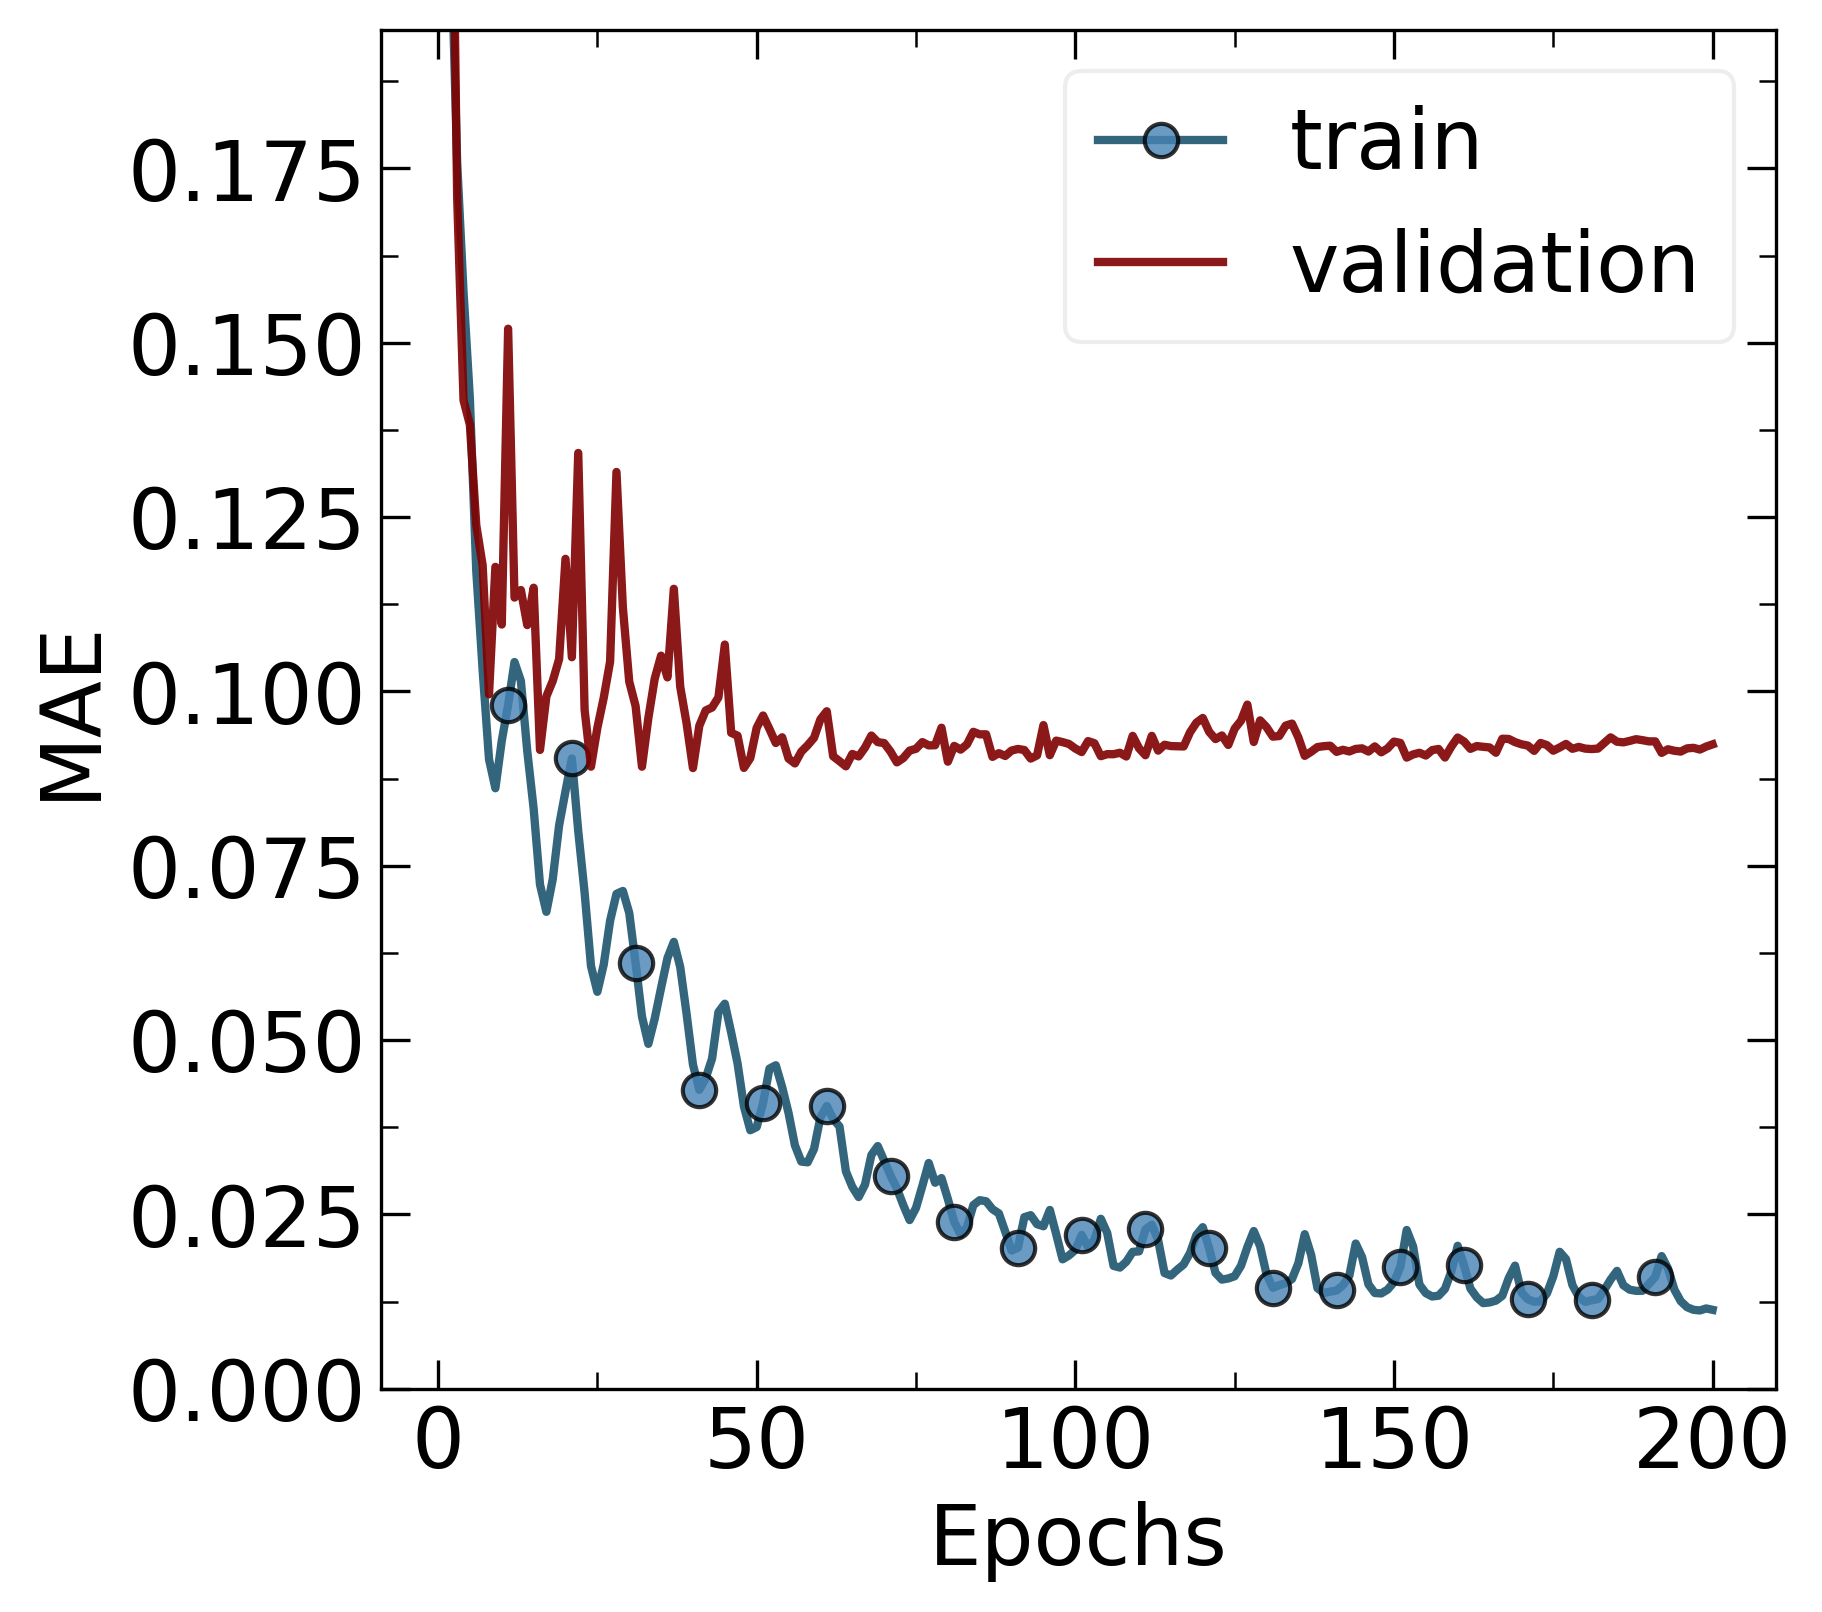

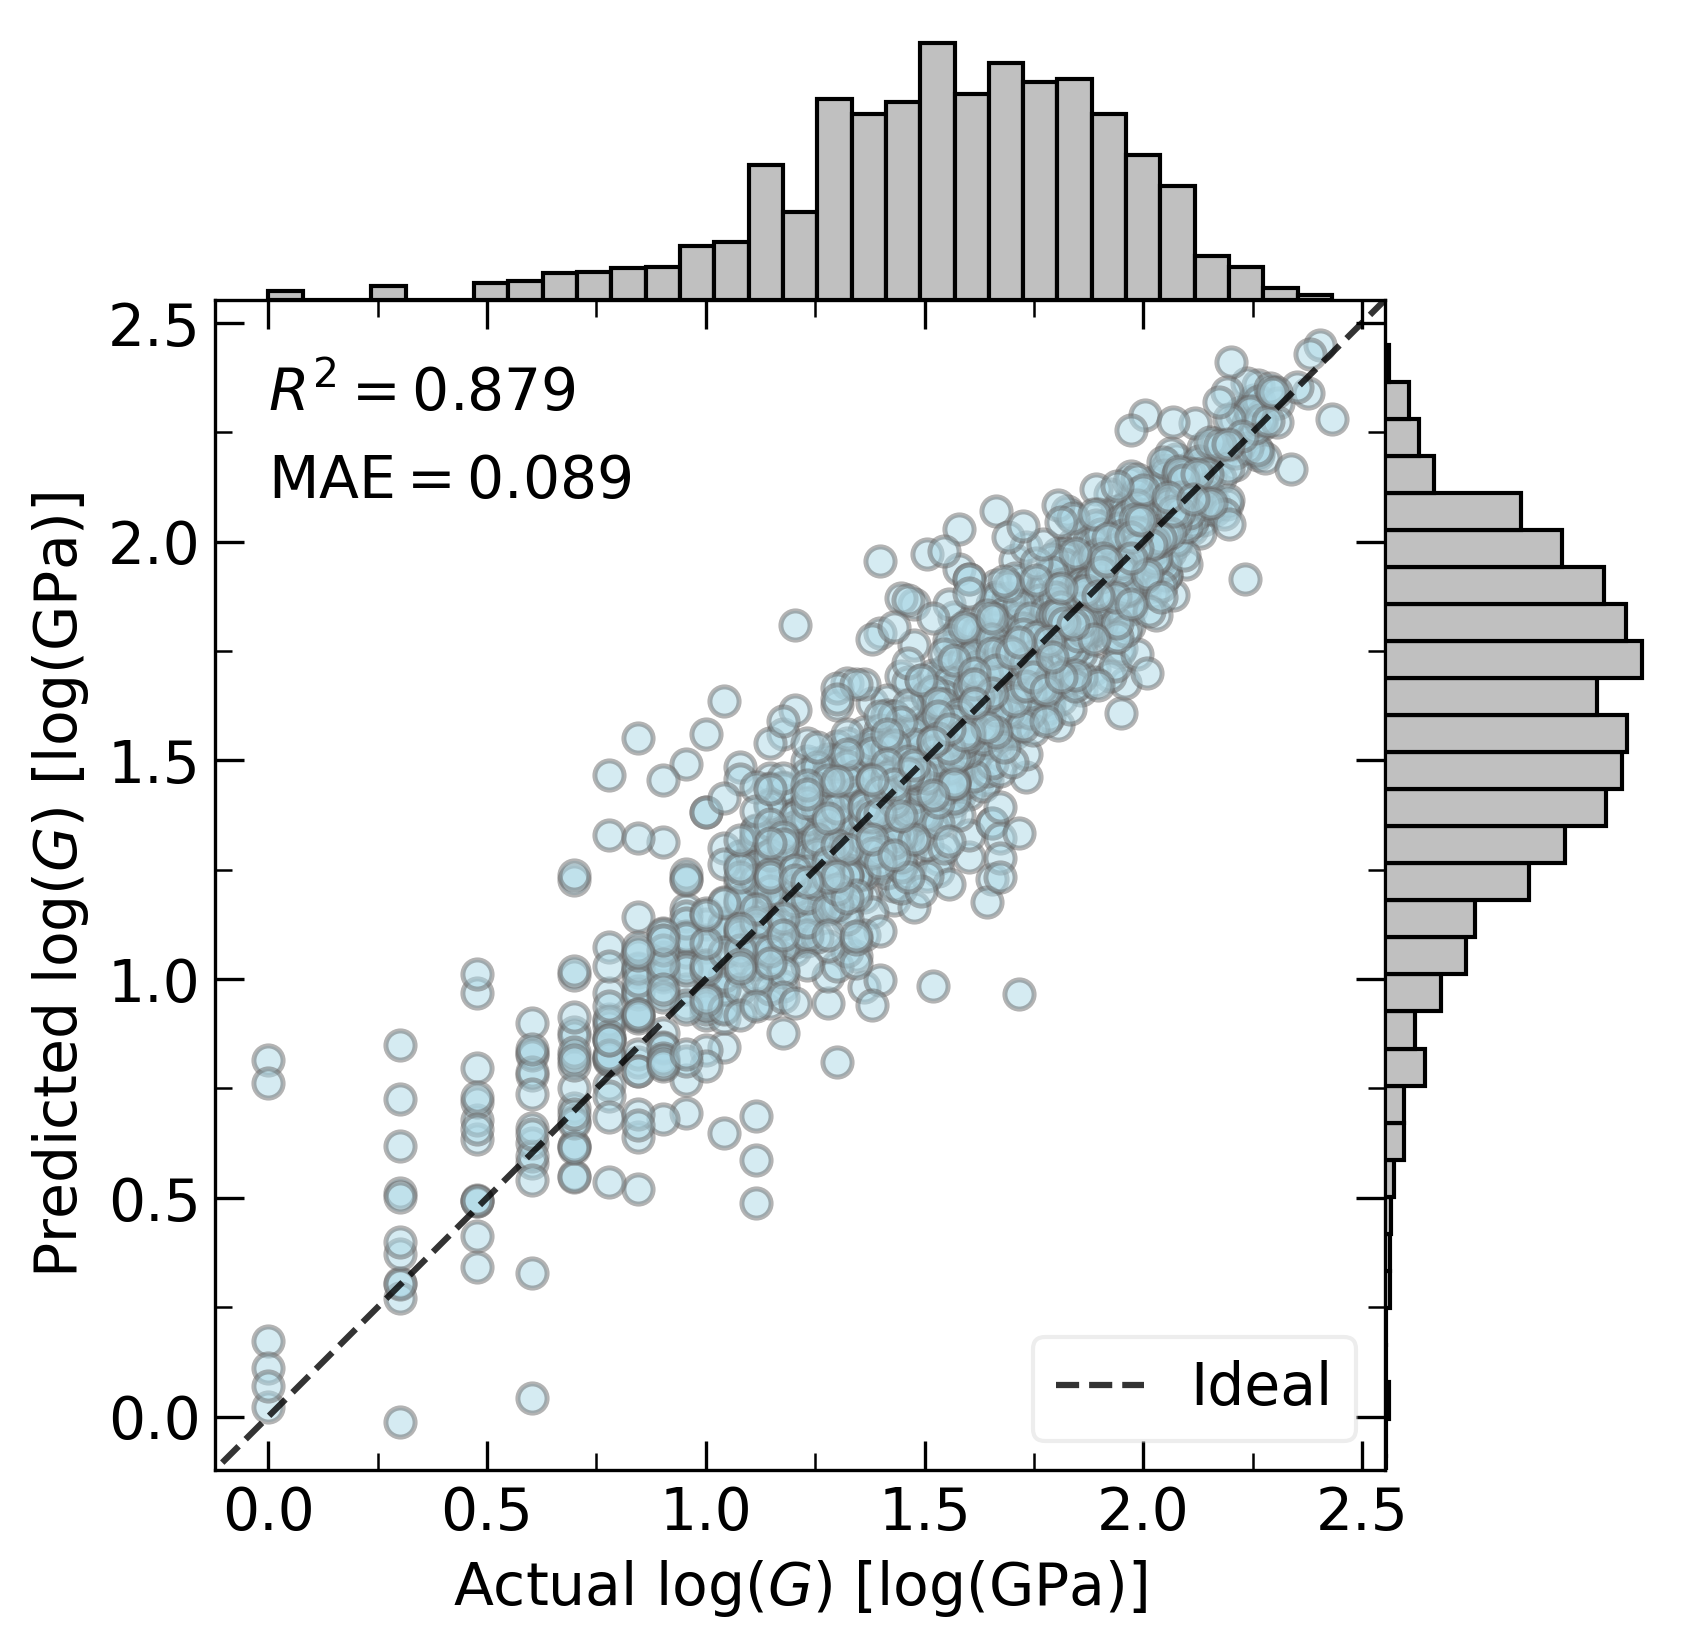

In [ ]:
# Test the model and save summary
test_loader = DataLoader(mat_test, batch_size=batch_size)
actual, predicted, mae_test, r2_test = test_inference(model, test_loader)
train_val = pd.DataFrame({'epoch': e,
                          'mae_train': mae_train,
                          'mae_val': mae_val,
                          'r2_train': r2_train,
                          'r2_val': r2_val})
test_results = pd.DataFrame({'mae_test': mae_test,
                             'r2_test': r2_test},
                            index=[0])
summary = pd.concat([train_val, test_results], axis=1)
path = 'drive/My Drive/DimeNet/saves/plots'
date = datetime.date.today().strftime('%m-%d')
summary.to_csv(f'{path}/eighty_{dataset}_{date}.csv', index=False)

# Loss curve
loss_curve(summary['epoch'], summary['mae_train'], summary['mae_val'],
           save_dir=path, name=f'eighty_{date}_{dataset}')

# Test plot
plt.rcParams.update({'font.size': 14})
act_pred(actual, predicted, target=dataset, mae=mae_test, r2=r2_test,
         save_dir=path, name=f'eighty_{date}_{dataset}')